INTRODUZIONE

Le email di phishing rappresentano una delle minacce più diffuse e pericolose nel campo della sicurezza informatica. Queste email fraudolente cercano di ingannare gli utenti spingendoli a rivelare informazioni sensibili come credenziali di accesso, informazioni finanziarie e altri dati personali. Il rilevamento automatico delle email di phishing è quindi una componente cruciale per proteggere gli utenti da queste minacce.

In questo progetto, svilupperemo un modello di machine learning per rilevare le email di phishing. Utilizzeremo un dataset di email etichettate come phishing e legittime per addestrare e valutare il nostro modello. Il processo comprende diverse fasi chiave, tra cui la pulizia e il preprocessing del testo, l'estrazione delle caratteristiche, la suddivisione del dataset in set di training e test, e l'addestramento del modello di classificazione.

OBIETTIVI

1. Raccolta e Preprocessing dei Dati: Caricare e pulire il dataset di email, estraendo le caratteristiche rilevanti per il rilevamento del phishing.
2. Addestramento del Modello: Utilizzare tecniche di machine learning per costruire un modello in grado di distinguere tra email legittime e phishing.
3. Valutazione delle Performance: Valutare il modello utilizzando metriche standard come precision, recall, F1-score e AUC-ROC.
4. Deployment: Creare un'API per permettere l'integrazione del modello in applicazioni reali.

1. Acquisizione Dati

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import classification_report, accuracy_score
import joblib
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, make_scorer
from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict
from sklearn.svm import SVC
from xgboost import XGBClassifier


   Unnamed: 0                                         Email Text  \
0           0  re : 6 . 1100 , disc : uniformitarianism , re ...   
1           1  the other side of * galicismos * * galicismo *...   
2           2  re : equistar deal tickets are you still avail...   
3           3  \nHello I am your hot lil horny toy.\n    I am...   
4           4  software at incredibly low prices ( 86 % lower...   

       Email Type  
0      Safe Email  
1      Safe Email  
2      Safe Email  
3  Phishing Email  
4  Phishing Email  
Email Type
Safe Email        11322
Phishing Email     7328
Name: count, dtype: int64
         Unnamed: 0
count  18650.000000
mean    9325.154477
std     5384.327293
min        0.000000
25%     4662.250000
50%     9325.500000
75%    13987.750000
max    18650.000000


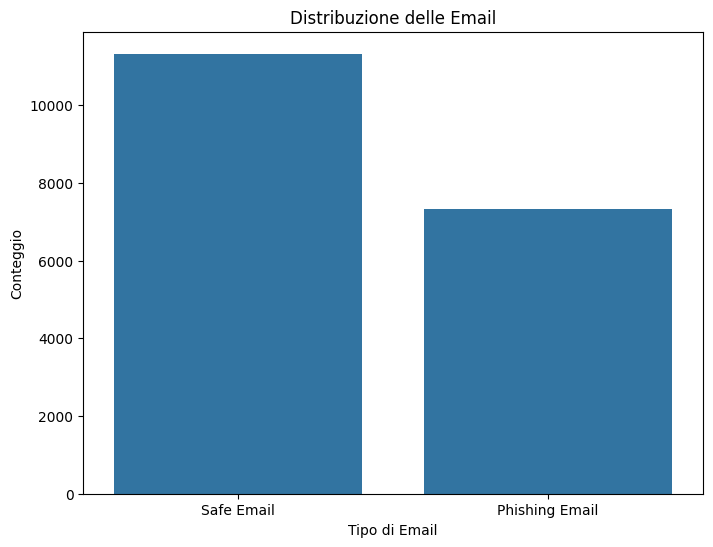

Unnamed: 0     0
Email Text    16
Email Type     0
dtype: int64
Unnamed: 0    0
Email Text    0
Email Type    0
dtype: int64
                  count         mean            std  min    25%    50%  \
Email Type                                                               
Phishing Email   7312.0  1613.924508    3352.191512  1.0  355.0  732.0   
Safe Email      11322.0  3493.008391  160168.024661  5.0  444.0  994.5   

                    75%         max  
Email Type                           
Phishing Email  1568.75    129635.0  
Safe Email      2029.75  17036692.0  


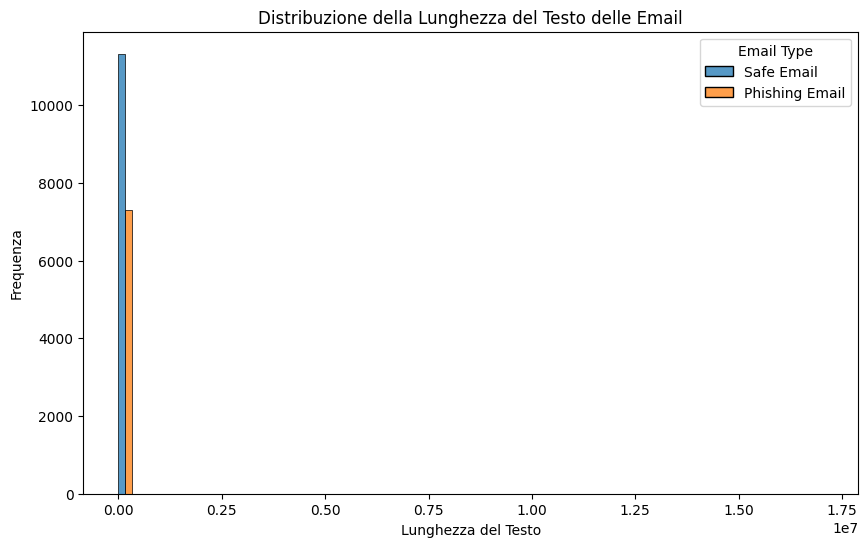

count    1.863400e+04
mean     2.755654e+03
std      1.248677e+05
min      1.000000e+00
25%      4.040000e+02
50%      8.815000e+02
75%      1.880000e+03
max      1.703669e+07
Name: Email Length, dtype: float64


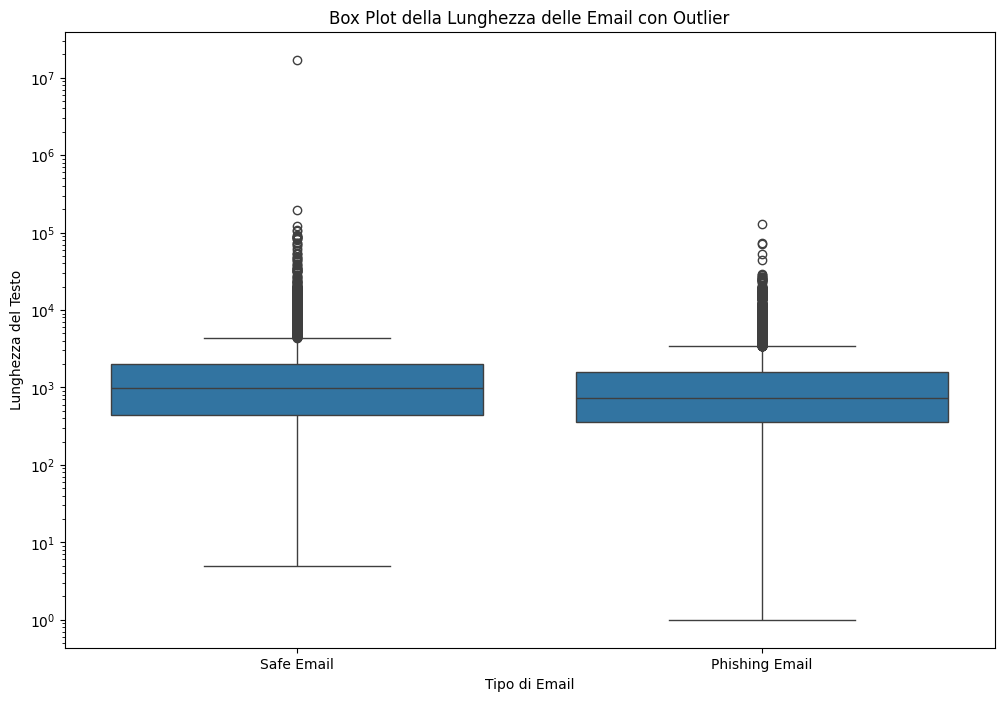

99° percentile della lunghezza delle email: 15662.83999999991


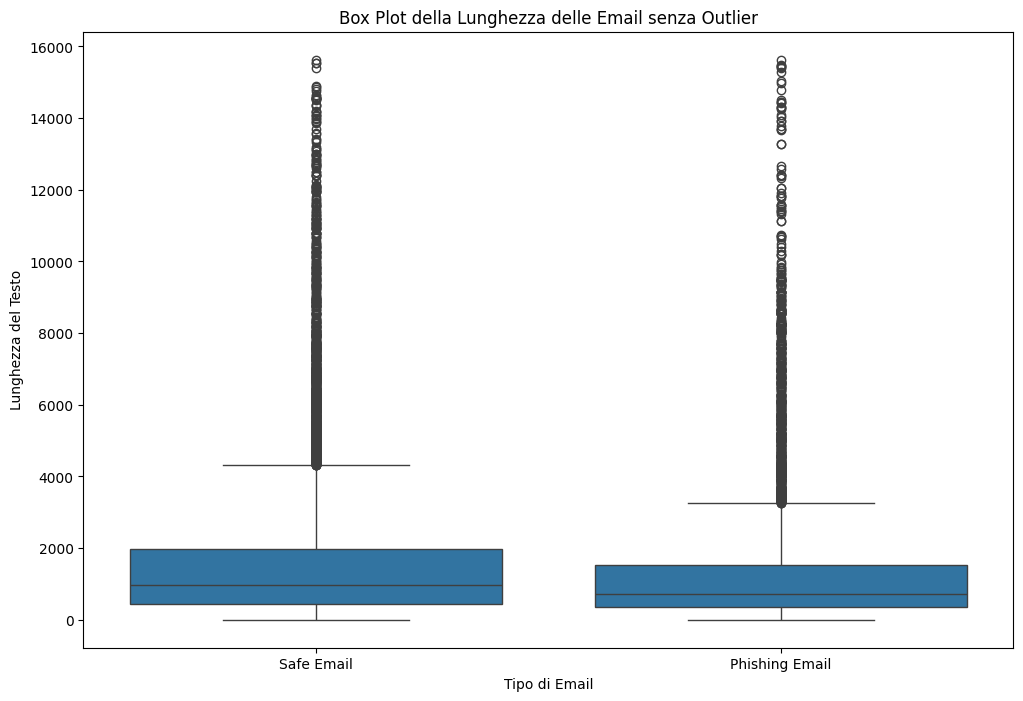

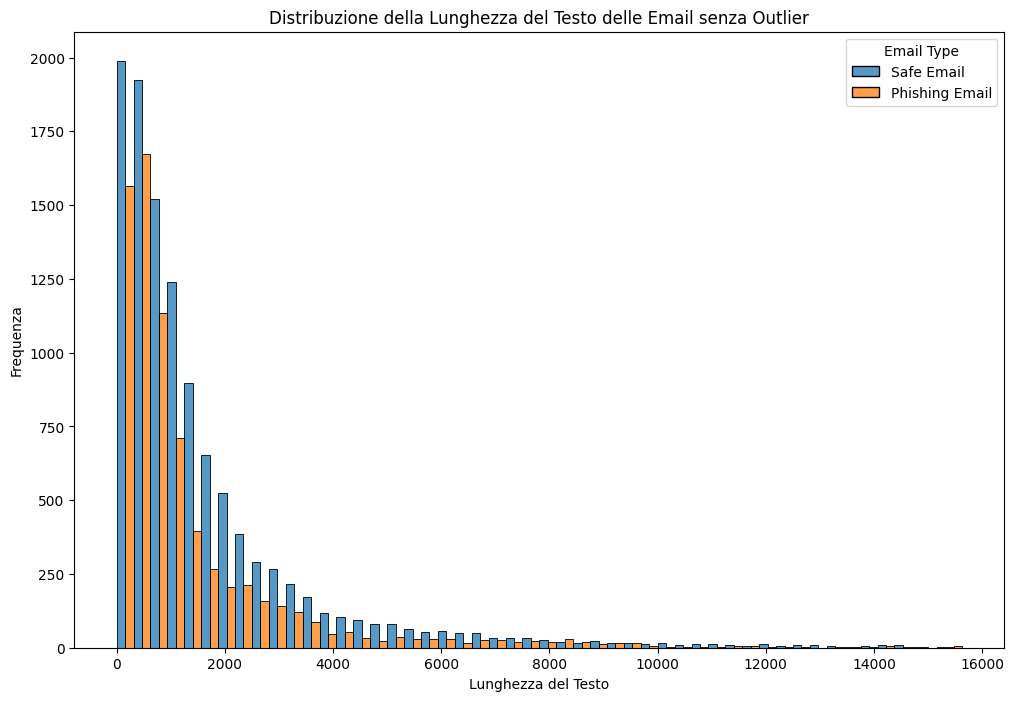

In [3]:
# Carico il dataset
dataset_path = r'C:\Users\alessandro\Desktop\desktop\workspace\PROGETTI PHYTON\datset\Phishing_Email.csv'
df = pd.read_csv(dataset_path)

# Visualizzo le prime righe del dataset
print(df.head())

# Controllo la distribuzione delle etichette
print(df['Email Type'].value_counts())

# Statistiche descrittive generali
print(df.describe())

# Visualizzazione della distribuzione delle etichette
plt.figure(figsize=(8, 6))
sns.countplot(x='Email Type', data=df)
plt.title('Distribuzione delle Email')
plt.xlabel('Tipo di Email')
plt.ylabel('Conteggio')
plt.show()

# Controllo e cancello dei valori mancanti
print(df.isnull().sum())
df.dropna(subset=['Email Text'], inplace=True)
print(df.isnull().sum())

# Aggiungo una colonna per la lunghezza del testo dell'email
df['Email Length'] = df['Email Text'].apply(len)
print(df.groupby('Email Type')['Email Length'].describe())

plt.figure(figsize=(10, 6))
sns.histplot(data=df, x='Email Length', hue='Email Type', bins=50, multiple='dodge', element='bars')
plt.title('Distribuzione della Lunghezza del Testo delle Email')
plt.xlabel('Lunghezza del Testo')
plt.ylabel('Frequenza')
plt.show()

# Verifico il range di lunghezza delle email
print(df['Email Length'].describe())

# Box plot per la lunghezza delle email con outlier
plt.figure(figsize=(12, 8))
sns.boxplot(data=df, x='Email Type', y='Email Length')
plt.title('Box Plot della Lunghezza delle Email con Outlier')
plt.xlabel('Tipo di Email')
plt.ylabel('Lunghezza del Testo')
plt.yscale('log')
plt.show()

# Calcolo il 99° percentile della lunghezza delle email
percentile_99 = df['Email Length'].quantile(0.99)
print(f"99° percentile della lunghezza delle email: {percentile_99}")

# Filtro il dataset per rimuovere gli outlier
df_filtered = df[df['Email Length'] <= percentile_99]

# Visualizzazione della distribuzione della lunghezza del testo senza outlier
plt.figure(figsize=(12, 8))
sns.boxplot(data=df_filtered, x='Email Type', y='Email Length')
plt.title('Box Plot della Lunghezza delle Email senza Outlier')
plt.xlabel('Tipo di Email')
plt.ylabel('Lunghezza del Testo')
plt.show()

plt.figure(figsize=(12, 8))
sns.histplot(data=df_filtered, x='Email Length', hue='Email Type', bins=50, multiple='dodge', element='bars')
plt.title('Distribuzione della Lunghezza del Testo delle Email senza Outlier')
plt.xlabel('Lunghezza del Testo')
plt.ylabel('Frequenza')
plt.show()


PREPOCESSING

In [4]:
# Funzione di pulizia del testo
def clean_text(text):
    if isinstance(text, float):
        return ""
    text = re.sub(r'<.*?>', '', text) # Rimuove HTML tags
    text = re.sub(r'\W', ' ', text)   # Rimuove caratteri speciali
    text = re.sub(r'\s+', ' ', text)  # Rimuove spazi multipli
    text = re.sub(r'\d', '', text)    # Rimuove numeri
    text = text.strip()               # Rimuove spazi all'inizio e alla fine
    return text

# Creo l'insieme delle stopwords
stop_words = set(stopwords.words('english'))

# Funzione per tokenizzare e rimuovere le stopwords
def tokenize_and_remove_stopwords(text):
    tokens = word_tokenize(text.lower())                                  # Converte il testo in minuscolo e lo tokenizza
    filtered_tokens = [word for word in tokens if word not in stop_words] # Rimuove le stopwords
    return filtered_tokens

# Creazione dell'oggetto stemmer
stemmer = PorterStemmer()

# Funzione per applicare lo stemmer ai token
def stem_tokens(tokens):
    stemmed_tokens = [stemmer.stem(word) for word in tokens]  # Applica lo stemming ai token
    return stemmed_tokens

# Funzione di preprocessamento del testo
def preprocess_text(text):
    cleaned_text = clean_text(text)                      # Pulisce il testo
    tokens = tokenize_and_remove_stopwords(cleaned_text) # Tokenizza e rimuove le stopwords
    stemmed_tokens = stem_tokens(tokens)                 # Applica lo stemming ai token
    return ' '.join(stemmed_tokens)                      # Unisce i token in una stringa

# Gestisci i valori NaN nella colonna 'Email Text'
df_filtered.loc[:, 'Email Text'] = df_filtered['Email Text'].fillna("")   # Sostituisce i valori NaN con stringhe vuote

# Applica il preprocessamento al DataFrame
df_filtered.loc[:, 'Processed Text'] = df_filtered['Email Text'].apply(preprocess_text)  # Applica il preprocessamento a ogni riga


# Visualizza le prime righe del dataset preprocessato
print(df_filtered.head())            # Stampa le prime righe del DataFrame preprocessato


   Unnamed: 0                                         Email Text  \
0           0  re : 6 . 1100 , disc : uniformitarianism , re ...   
1           1  the other side of * galicismos * * galicismo *...   
2           2  re : equistar deal tickets are you still avail...   
3           3  \nHello I am your hot lil horny toy.\n    I am...   
4           4  software at incredibly low prices ( 86 % lower...   

       Email Type  Email Length  \
0      Safe Email          1030   
1      Safe Email           479   
2      Safe Email          1245   
3  Phishing Email           688   
4  Phishing Email           441   

                                      Processed Text  
0  disc uniformitarian sex lang dick hudson obser...  
1  side galicismo galicismo spanish term name imp...  
2  equistar deal ticket still avail assist robert...  
3  hello hot lil horni toy one dream open mind pe...  
4  softwar incred low price lower draperi sevente...  


C:\Users\alessandro\AppData\Local\Temp\ipykernel_12344\1645113108.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered.loc[:, 'Processed Text'] = df_filtered['Email Text'].apply(preprocess_text)


creazione della rappresentazione TF-idf

In [5]:
# Creazione della rappresentazione TF-IDF
vectorizer = TfidfVectorizer()                                                    # Creo un oggetto vettorizzatore TF-IDF per trasformare il testo in una rappresentazione numerica
X = vectorizer.fit_transform(df_filtered['Processed Text'])                       # Questo trasforma il testo in una matrice TF-IDF, dove ogni riga è un documento e ogni colonna è un termine

# Creazione delle etichette
y = df_filtered['Email Type'].apply(lambda x: 1 if x == 'Phishing Email' else 0)  # Crea un array di etichette binarie basato sulla colonna 'Email Type', assegna 1 se il tipo di email è 'Phishing Email', altrimenti assegna 0


ADDESTRAMENTO DEL MODELLO

In [6]:
# Divido i dati in set di addestramento e test, rispettivamente 80/20
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Modello Random Forest
rf_model = RandomForestClassifier()
rf_model.fit(X_train, y_train)
y_pred_rf = rf_model.predict(X_test)
accuracy_rf = accuracy_score(y_test, y_pred_rf)
classification_report_rf = classification_report(y_test, y_pred_rf)
print("Accuracy with Random Forest:", accuracy_rf)
print("Classification Report with Random Forest:\n", classification_report_rf)

# Modello XGBoost
from xgboost import XGBClassifier
xgb_model = XGBClassifier(eval_metric='mlogloss')
xgb_model.fit(X_train, y_train)
y_pred_xgb = xgb_model.predict(X_test)
accuracy_xgb = accuracy_score(y_test, y_pred_xgb)
classification_report_xgb = classification_report(y_test, y_pred_xgb)
print("Accuracy with XGBoost:", accuracy_xgb)
print("Classification Report with XGBoost:\n", classification_report_xgb)

# Modello SVM
svm_model = SVC(kernel='linear')                                         # Creo un modello SVM con kernel lineare
svm_model.fit(X_train, y_train)                                          # addestramento
y_pred_svm = svm_model.predict(X_test)                                   # previsioni sul test
accuracy_svm = accuracy_score(y_test, y_pred_svm)                        # calcolo accuratezza
classification_report_svm = classification_report(y_test, y_pred_svm)    # report di classificazione
print("Accuracy with SVM:", accuracy_svm)
print("Classification Report with SVM:\n", classification_report_svm)


Accuracy with Random Forest: 0.9590785907859078
Classification Report with Random Forest:
               precision    recall  f1-score   support

           0       0.97      0.97      0.97      2246
           1       0.95      0.95      0.95      1444

    accuracy                           0.96      3690
   macro avg       0.96      0.96      0.96      3690
weighted avg       0.96      0.96      0.96      3690

Accuracy with XGBoost: 0.9609756097560975
Classification Report with XGBoost:
               precision    recall  f1-score   support

           0       0.98      0.95      0.97      2246
           1       0.93      0.97      0.95      1444

    accuracy                           0.96      3690
   macro avg       0.96      0.96      0.96      3690
weighted avg       0.96      0.96      0.96      3690

Accuracy with SVM: 0.975609756097561
Classification Report with SVM:
               precision    recall  f1-score   support

           0       0.99      0.97      0.98      22

In [7]:
# Salvo il modello SVM
joblib.dump(svm_model, 'svm_model.pkl')          # uso joblib per salvare il modello addestarto nel file svm_model.pkl, in modo che posso riutilizzarlo

# Salvo il vettorizzatore TF-IDF
joblib.dump(vectorizer, 'tfidf_vectorizer.pkl')


['tfidf_vectorizer.pkl']

Cross-Validation

In [8]:
# Definisco lo scorer per la cross-validation, utilizzando la funzione accuracy_score come metrica di valutazione per la cross-validation
scorer = make_scorer(accuracy_score)

# Modello Random Forest con Cross-Validation
rf_model = RandomForestClassifier()
rf_cv_scores = cross_val_score(rf_model, X, y, cv=5, scoring=scorer)  # Esegue la cross-validation 5-fold sul modello Random Forest usando accuracy_score come metrica
rf_model.fit(X_train, y_train)
y_pred_rf = rf_model.predict(X_test)
accuracy_rf = accuracy_score(y_test, y_pred_rf)
classification_report_rf = classification_report(y_test, y_pred_rf)
print("Random Forest - Cross-Validation Scores:", rf_cv_scores)
print("Random Forest - Mean CV Accuracy:", np.mean(rf_cv_scores))
print("Accuracy with Random Forest:", accuracy_rf)
print("Classification Report with Random Forest:\n", classification_report_rf)

# Modello XGBoost con Cross-Validation
xgb_model = XGBClassifier(eval_metric='mlogloss')
xgb_cv_scores = cross_val_score(xgb_model, X, y, cv=5, scoring=scorer)
xgb_model.fit(X_train, y_train)
y_pred_xgb = xgb_model.predict(X_test)
accuracy_xgb = accuracy_score(y_test, y_pred_xgb)
classification_report_xgb = classification_report(y_test, y_pred_xgb)
print("XGBoost - Cross-Validation Scores:", xgb_cv_scores)
print("XGBoost - Mean CV Accuracy:", np.mean(xgb_cv_scores))
print("Accuracy with XGBoost:", accuracy_xgb)
print("Classification Report with XGBoost:\n", classification_report_xgb)

# Modello SVM con Cross-Validation
svm_model = SVC(kernel='linear')
svm_cv_scores = cross_val_score(svm_model, X, y, cv=5, scoring=scorer)
svm_model.fit(X_train, y_train)
y_pred_svm = svm_model.predict(X_test)
accuracy_svm = accuracy_score(y_test, y_pred_svm)
classification_report_svm = classification_report(y_test, y_pred_svm)
print("SVM - Cross-Validation Scores:", svm_cv_scores)
print("SVM - Mean CV Accuracy:", np.mean(svm_cv_scores))
print("Accuracy with SVM:", accuracy_svm)
print("Classification Report with SVM:\n", classification_report_svm)


Random Forest - Cross-Validation Scores: [0.96314363 0.96151762 0.96069396 0.95933857 0.96123611]
Random Forest - Mean CV Accuracy: 0.9611859766198638
Accuracy with Random Forest: 0.9585365853658536
Classification Report with Random Forest:
               precision    recall  f1-score   support

           0       0.97      0.97      0.97      2246
           1       0.95      0.95      0.95      1444

    accuracy                           0.96      3690
   macro avg       0.96      0.96      0.96      3690
weighted avg       0.96      0.96      0.96      3690

XGBoost - Cross-Validation Scores: [0.96260163 0.95663957 0.95825427 0.95635674 0.95988073]
XGBoost - Mean CV Accuracy: 0.9587465849177331
Accuracy with XGBoost: 0.9609756097560975
Classification Report with XGBoost:
               precision    recall  f1-score   support

           0       0.98      0.95      0.97      2246
           1       0.93      0.97      0.95      1444

    accuracy                           0.96      

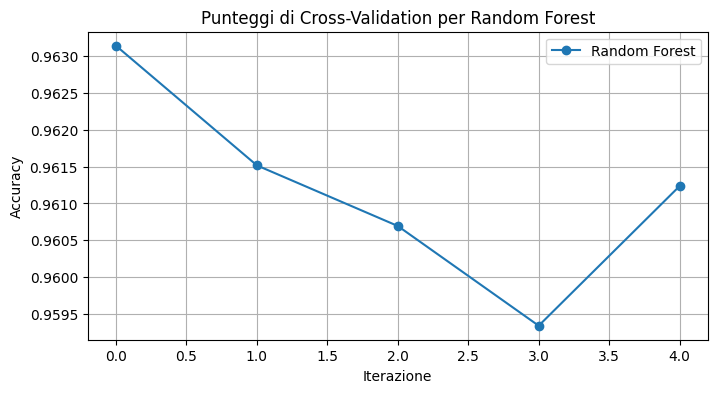

Random Forest - Punteggi di Cross-Validation: [0.96314363 0.96151762 0.96069396 0.95933857 0.96123611]
Random Forest - Media dei punteggi di Cross-Validation: 0.9611859766198638


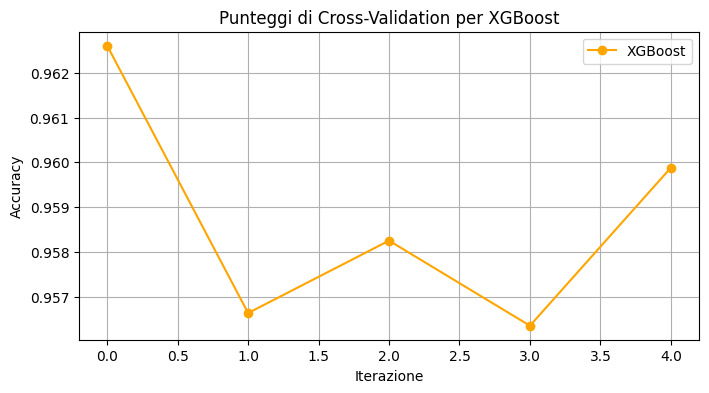

XGBoost - Punteggi di Cross-Validation: [0.96260163 0.95663957 0.95825427 0.95635674 0.95988073]
XGBoost - Media dei punteggi di Cross-Validation: 0.9587465849177331


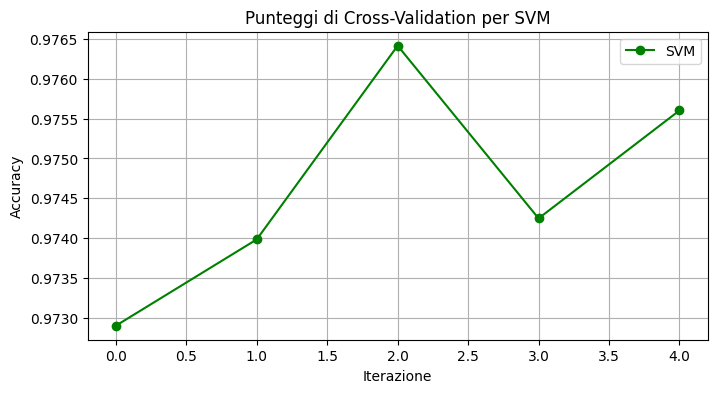

SVM - Punteggi di Cross-Validation: [0.97289973 0.97398374 0.97641637 0.97424776 0.97560314]
SVM - Media dei punteggi di Cross-Validation: 0.9746301499881358


In [10]:
# Visualizzazione dei punteggi di cross-validation per Random Forest
plt.figure(figsize=(8, 4))
plt.plot(rf_cv_scores, marker='o', label='Random Forest')
plt.title("Punteggi di Cross-Validation per Random Forest")
plt.ylabel("Accuracy")
plt.xlabel("Iterazione")
plt.grid(True)
plt.legend()
plt.show()

# Stampa dei punteggi per Random Forest
print("Random Forest - Punteggi di Cross-Validation:", rf_cv_scores)
print("Random Forest - Media dei punteggi di Cross-Validation:", rf_cv_scores.mean())

# Visualizzazione dei punteggi di cross-validation per XGBoost
plt.figure(figsize=(8, 4))
plt.plot(xgb_cv_scores, marker='o', label='XGBoost', color='orange')
plt.title("Punteggi di Cross-Validation per XGBoost")
plt.ylabel("Accuracy")
plt.xlabel("Iterazione")
plt.grid(True)
plt.legend()
plt.show()

# Stampa dei punteggi per XGBoost
print("XGBoost - Punteggi di Cross-Validation:", xgb_cv_scores)
print("XGBoost - Media dei punteggi di Cross-Validation:", xgb_cv_scores.mean())

# Visualizzazione dei punteggi di cross-validation per SVM
plt.figure(figsize=(8, 4))
plt.plot(svm_cv_scores, marker='o', label='SVM', color='green')
plt.title("Punteggi di Cross-Validation per SVM")
plt.ylabel("Accuracy")
plt.xlabel("Iterazione")
plt.grid(True)
plt.legend()
plt.show()

# Stampa dei punteggi per SVM
print("SVM - Punteggi di Cross-Validation:", svm_cv_scores)
print("SVM - Media dei punteggi di Cross-Validation:", svm_cv_scores.mean())

SVM sembra essere il modello più stabile e performante con punteggi di cross-validation alti e costanti.

Accuracy with SVM: 0.975609756097561
Classification Report with SVM:
               precision    recall  f1-score   support

           0       0.99      0.97      0.98      2246
           1       0.95      0.99      0.97      1444

    accuracy                           0.98      3690
   macro avg       0.97      0.98      0.97      3690
weighted avg       0.98      0.98      0.98      3690



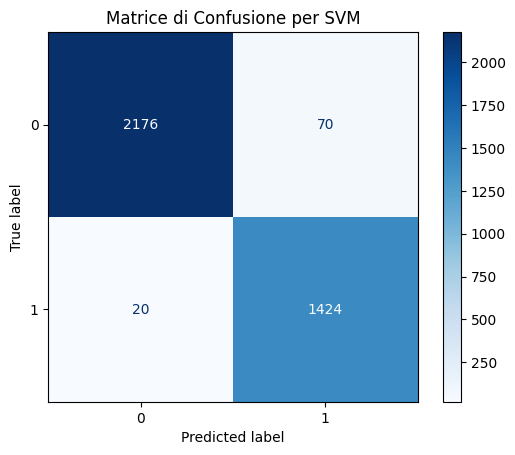

In [11]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Calcolo delle metriche finali sul set di test per il modello SVM
accuracy_svm = accuracy_score(y_test, y_pred_svm)
classification_report_svm = classification_report(y_test, y_pred_svm)
conf_matrix_svm = confusion_matrix(y_test, y_pred_svm)

print("Accuracy with SVM:", accuracy_svm)
print("Classification Report with SVM:\n", classification_report_svm)

# Visualizzazione della matrice di confusione
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix_svm, display_labels=rf_model.classes_)
disp.plot(cmap=plt.cm.Blues)
plt.title("Matrice di Confusione per SVM")
plt.show()


Discussione dei Risultati

Il modello SVM ha dimostrato prestazioni eccellenti con un'accuratezza del 97%. La precisione e il recall per entrambe le classi sono molto alti, indicando che il modello è altamente efficace nel distinguere tra email legittime e email di phishing. La bassa quantità di falsi positivi (FP) e falsi negativi (FN) suggerisce che il modello è ben bilanciato e affidabile.